<a href="https://colab.research.google.com/github/BHouwens/kitchen_sink/blob/main/templates/CVPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision (CV) Prediction**

Computer Vision (or CV) modeling takes data in the form of images, where the objective is to predict some class/es (classification) or some quantity (regression) for each entry in the dataset. This notebook will serve as a boilerplate handler for CV modeling, with sections laid out for each major step of the modeling process. 

This notebook will *not* deal with detection, segmentation or GAN-related work; these will be available in their own notebooks.

..

---



**REMEMBER**: This boilerplate is just that: boilerplate! It's a good idea to perform your own exploration in a manner that's specific to your given dataset. The default boilerplate uses the Titanic dataset from Kaggle as an example.

## **Setup**

This section will contain everything you need to get set up in your environment, including all imports and installations that you may require for your project.

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
# export
COLOURS = {
    'Reset': "\x1b[0m",
    'Bright': "\x1b[1m",
    'Dim': "\x1b[2m",
    'Underscore': "\x1b[4m",
    'Blink': "\x1b[5m",
    'Reverse': "\x1b[7m",
    'Hidden': "\x1b[8m",
    'FgBlack': "\x1b[30m",
    'FgRed': "\x1b[31m",
    'FgGreen': "\x1b[32m",
    'FgYellow': "\x1b[33m",
    'FgBlue': "\x1b[34m",
    'FgMagenta': "\x1b[35m",
    'FgCyan': "\x1b[36m",
    'FgWhite': "\x1b[37m",
    'BgBlack': "\x1b[40m",
    'BgRed': "\x1b[41m",
    'BgGreen': "\x1b[42m",
    'BgYellow': "\x1b[43m",
    'BgBlue': "\x1b[44m",
    'BgMagenta': "\x1b[45m",
    'BgCyan': "\x1b[46m",
    'BgWhite': "\x1b[47m"
}

def pretty_log(msg, msg_type='info'):
  print("")
  print("{c}//===== {m} =====//{r}".format(c=COLOURS['FgBlue'], m=msg, r=COLOURS['Reset']))
  print("")

### **Imports and Installs**

Here you can import and install all your required dependencies here. Feel free to change or update these as your project requires.

In [4]:
# Installs
!pip install -Uqq fastai

     |████████████████████████████████| 204kB 7.4MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 


In [5]:
# Imports
from fastai.vision.all import *
import numpy as np
import math
import seaborn as sn

### **Environment Setup**

This will get you set up in a Colab environment, with your Google Drive mounted and ready to read and write data

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/

Mounted at /content/gdrive
/content/gdrive/My Drive


..


---



## **Data Collection**

This section contains all the code necessary to pull in the relevant data for your project

In [ ]:
# FETCH YOUR DATA HERE

### **Example**

This is an example section. Feel free to delete this and replace it with your own data collection process.

In [7]:
# Let's try an example with fastai
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

We can see that this dataset provides us with *images* and *annotations* directories. The [website](https://www.robots.ox.ac.uk/~vgg/data/pets/) for the dataset tells us that the *annotations* directory contains information about where the pets are rather than what they are. In this chapter, we will be doing classification, not localization, which is to say that we care about what the pets are, not where they are. Therefore, we will ignore the *annotations* directory for now. So, let's have a look inside the *images* directory:

In [ ]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_61.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_71.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_73.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_28.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_84.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_146.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_208.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_134.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_198.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_140.jpg')...]

Great! Now that we have our data we can proceed to explore it a little.

..



---



## **Exploratory Data Analysis**

EDA can be performed here, where you'll find cells for showing batches, as well as utility functions for displaying certain analytics. It also contains headings to prompt some thinking about possible exploratory approaches.

In [ ]:
# EXPLORE ALL YOUR FANTASTIC DATA HERE!

### **DataBlock Handling**

Here we can define augmentations for our dataset before we place it into a `DataBlock` format. If you're not using fastai, you can ignore this section completely.

In [16]:
# export

def get_dls(path, get_y, batch_size, image_size):
    """
    Constructs a DataBlock DLS for images, with a categorical 
    output.
    """
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=get_y,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=image_size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=batch_size)

### **Example**

This is an example section. Feel free to delete this and replace it with your own data collection process.

Since the pet breed is contained in the file name, we can use Regex to extract as part of the data transformation process.

In [8]:
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Birman']

That works, so let's proceed to stick this into a Fastai `DataBlock`:

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

And we can then take a look at our data more closely

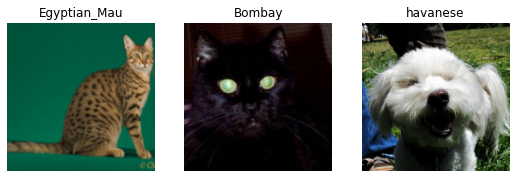

In [10]:
dls.show_batch(nrows=1, ncols=3)

Let's check on the data normalisation:

In [11]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.4641, 0.4290, 0.3797], device='cuda:0'),
 TensorImage([0.2615, 0.2528, 0.2653], device='cuda:0'))

As expected the data hasn't been normalised in a way that would help a linear model out. We can use the utility function from the `DataBlock` handling section above:

In [17]:
dls = get_dls(path, parent_label, 64, 224)

x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-1.0058, -0.9895, -0.8778], device='cuda:0'),
 TensorImage([1.3354, 1.2935, 1.2253], device='cuda:0'))

Now that we've had a chance to explore the data, we can proceed to push it through a model and see if we can perform some prediction.

..



---



## **Model**

Model work can be performed here, with utilities to help with cross-validation and architecture construction.

In [ ]:
# PERFORM MODEL WORK HERE

### **Example**

This is an example section. Feel free to delete this and replace it with your own data collection process.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.504486,0.366183,0.116373,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.501352,0.339225,0.114344,01:00
1,0.316284,0.237438,0.086604,01:00


We can now try to interpret some of the results from our model here:

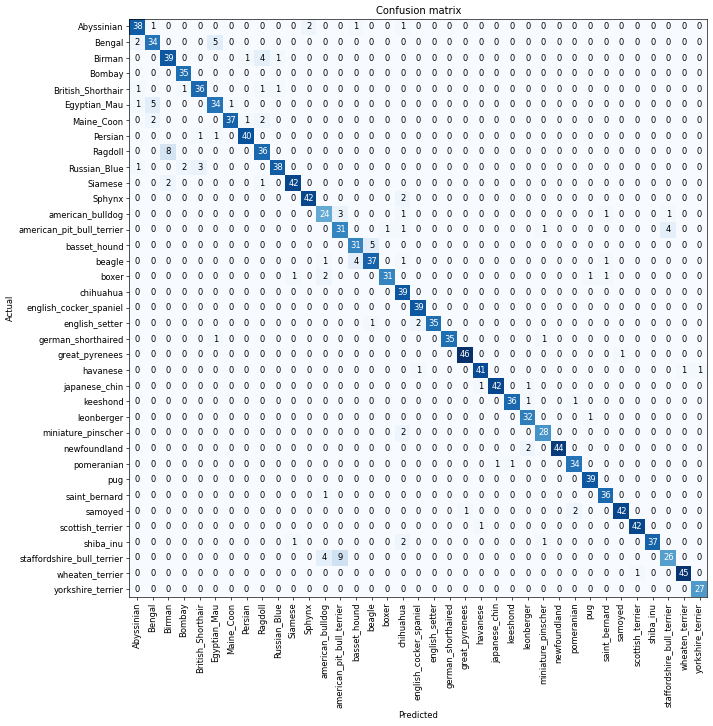

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 9),
 ('Ragdoll', 'Birman', 8),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Egyptian_Mau', 'Bengal', 5),
 ('basset_hound', 'beagle', 5)]

Great, now that we have a working model we can proceed to export and get ready for implementation in future projects.

..



---



## **Export and Clean Up**

Our model can be exported in this section, as well as any clean up of the environment that we may be running the notebook in.

In [ ]:
!python notebook2script.py CVPrediction.ipynb

In [ ]:
# Tear down the data folder
!rm -rf data
!ls

..